# Model demo and validation

This notebook illustrates how the model is desinged to be used.
It also visualizes some of the core components and compares/validates the results
against the results from the MATLAB code provided by Adrian Burd (see "coag_model_adrian_matlab").

In [1]:
from coagulation_model.coagulation_kernel import CoagulationKernel as kernel
from coagulation_model.sectional_volume_concentration_changes import SectionalVolumeConcentrationChanges
from coagulation_model.sectional_coagulation_kernels import SectionalCoagulationKernels
from coagulation_model.particle_size_distribution import ParticleSizeDistribution as psd

from coagulation_model.plotting import plot_kernel_map
from coagulation_model.plotting import plot_sectional_kernels
from coagulation_model.plotting import plot_particle_size_classes
from coagulation_model.plotting import plot_particle_size_distribution

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta
sns.set_context('notebook')

## Initializing a particle distribution


The model is designed with the "particle distribution" in its center.
The "particle size distribution" describes the amount of particles in each size class.
Size classes are defined by their mean radius and double in volume with each class.

To start we define an initial particle size distribution.
Here we use a distribution that declines exponentially with radius,
such that each each class declined by a factor of 10 compared to the previous class,
based on the matlab code provided..


In [2]:
particle_size_distribution = psd(radius_sphere_min = 1e-6,radius_sphere_max = 1.1e-4,
                                 type='log10_decline',kwargs={'initial_volume_concentration': 6.283e-6})

(<Figure size 1000x100 with 1 Axes>, <Axes: xlabel='particle radius [m]'>)

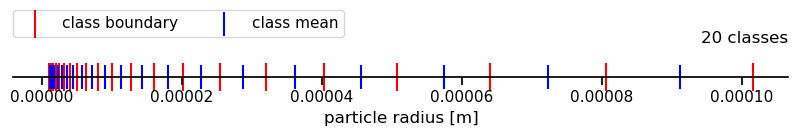

In [3]:
# Visulization of the particle size classes

# volume of each size class 
volume_boundary_spheres = particle_size_distribution.radius_boundary_spheres**3

# plot the volume on a number line
plot_particle_size_classes(particle_size_distribution.radius_boundary_spheres)

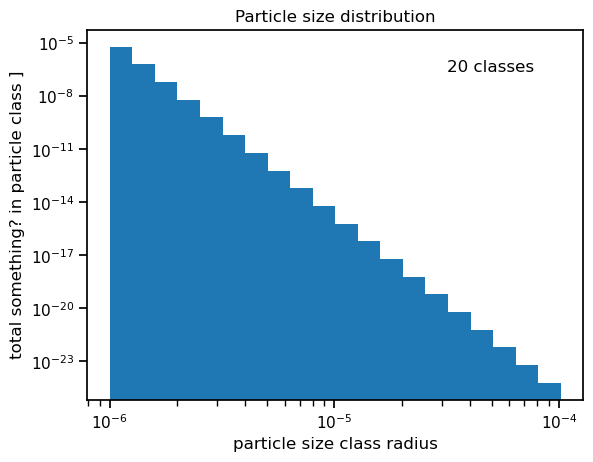

In [4]:
# Visulization of the particle size distribution

fig1, ax1 = plot_particle_size_distribution(particle_size_distribution,y_axis_scale='log')

## Coagulation kernels

The coagulation kernel describes the rate of coagulation between particles in each size class.
Here we use a differential sedimentation kernel as an example, which is a function of the settling velocity
and the size of the particles.
Coagulation kernels can be added together to calculated to total coagulation kernels.

Kernels (e.g. rectilinear_shear or rectilinear_differential_sedimentation) are defined in the kernel class.
In the same class containts the different settling functions (e.g. jackson_lochmann_fractal) that can be used out of the box.

In [5]:
coagulation_kernel = kernel(
    list_of_applied_kernels=[
        # 'rectilinear_shear',
        'rectilinear_differential_sedimentation',
        ],
    settling_function='settling_velocity_jackson_lochmann_fractal'
    )

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Radius of particle i (m)', ylabel='Radius of particle j (m)'>)

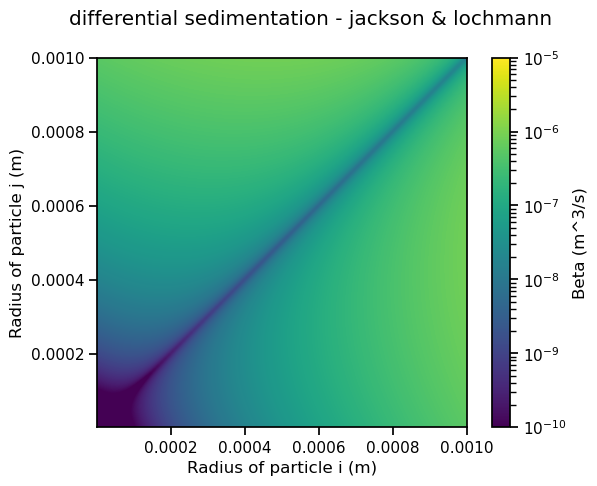

In [6]:
# Visualization of the coagulation kernel
plot_kernel_map(coagulation_kernel, 'differential sedimentation - jackson & lochmann', norm_range = [1e-10, 1e-5], scale='lin')

## Sectional coagulation kernels

While the coagulation kernel describes the coagulation rate between particles of a certain radius, or volume, 
the sectional coagulation kernel describes the movement of particles between size classes due to size changes after coagulation based on different interaction types (e.g. equally sized aggregates coagulating with each other, aggregates interacting with smaller aggregegates).
The sectional coagulation kernels are a function of the coagulation kernels and the particle size distribution and don't over any used defined parameters.

In [7]:
sectional_kernel = SectionalCoagulationKernels(coagulation_kernel,particle_size_distribution)

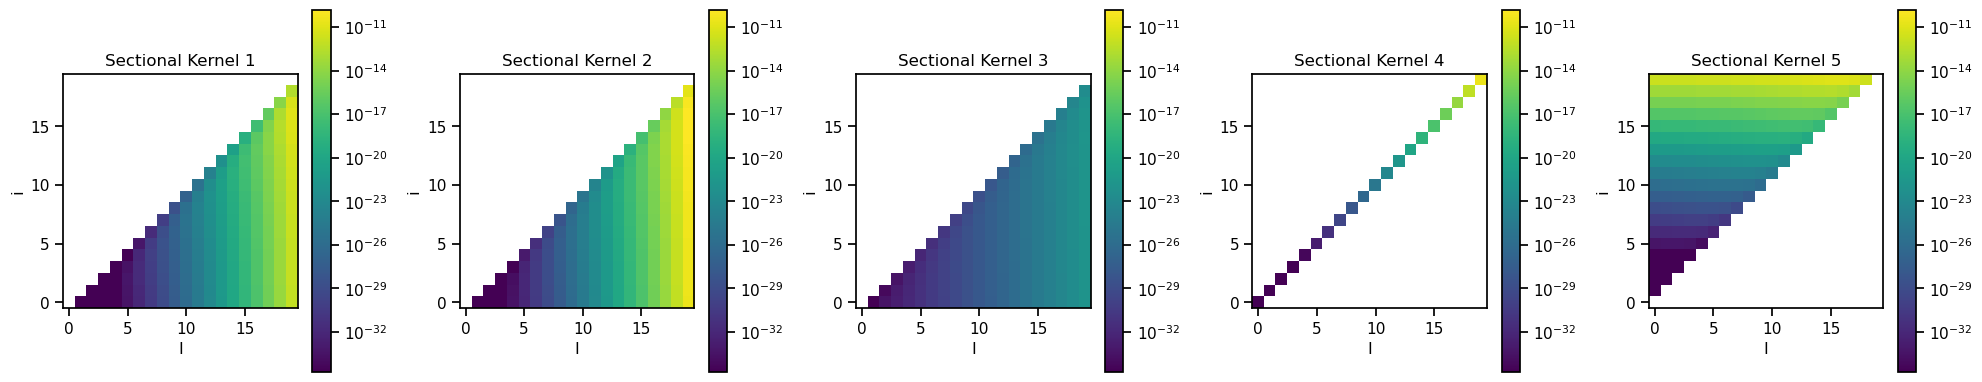

In [8]:
fig,ax = plot_sectional_kernels(sectional_kernel.data)

## Reference data

For the time being we are not able to reproduce the results from the MATLAB code based on the description in the Jackson and Lochmann paper.
Therefore we use the MATLAB code to provide the sectional coagulation kernels instead and use the other results i.e. the initial particle size distribution and the initial mass changes at t=0 as a reference for validation.

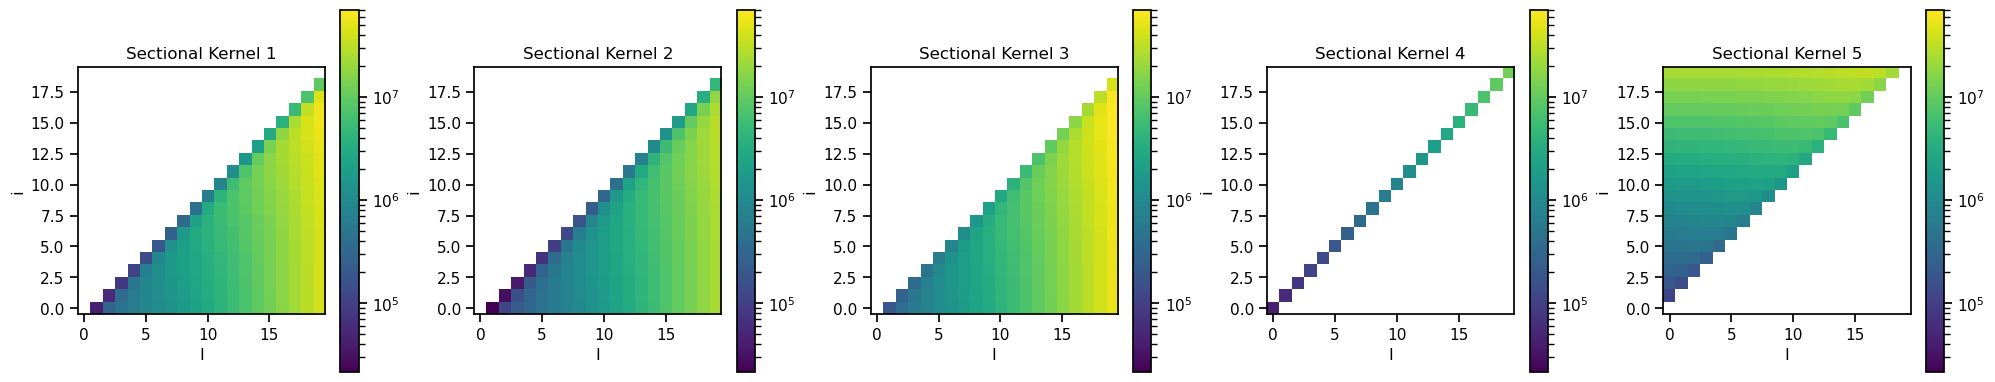

In [9]:
# inistial sectional mass distribution from burds matlab code
matlab_particle_size_distribution = np.array([0.6283e-05, 0.0628e-05, 0.0063e-05, 0.0006e-05, 0.0001e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05])
# sectional mass changes at t=0 from burds matlab code
dvdt = np.array([-0.2244e-05, 0.0984e-05, 0.1037e-05, 0.0192e-05, 0.0027e-05, 0.0003e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05, 0.0000e-05])

def read_beta_files(num_files, directory="../coag_model_adrian_matlab"):
    """
    Read beta_i.txt files into a 3D numpy array.
    
    Args:
        num_files (int): Number of beta files to read (beta_1.txt to beta_n.txt)
        directory (str): Directory containing the beta files
        
    Returns:
        numpy.ndarray: 3D array of shape (num_files, 20, 20) containing all beta matrices
    """
    # Initialize 3D array to store all beta matrices
    beta_matrices = np.zeros((num_files, 20, 20))
    
    # Read each beta file
    for i in range(num_files):
        file_path = f"{directory}/beta_{i+1}.txt"
        try:
            beta_matrices[i] = np.loadtxt(file_path,delimiter=',')
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            
    return beta_matrices

matlab_betas = read_beta_files(5)


sectional_kernel_matlab = SectionalCoagulationKernels(coagulation_kernel,particle_size_distribution)
sectional_kernel_matlab.data = matlab_betas

# fig, ax = plot_sectional_kernels(np.array([sectional_kernel_matlab.data[jj]]))
fig, ax = plot_sectional_kernels(sectional_kernel_matlab.data)

## Time evolution and the sectional volume derivative

The sectional volume derivative is the rate of change in volume concentration of particles in each size class.
The following calculates the sectional volume derivative based on the model and compares it to the reference data.

In [10]:
# current "native" but buggy implementation
# sectional_mass_changes = SectionalVolumeConcentrationChanges(sectional_kernel,particle_size_distribution)
# sectional_mass_changes.data = sectional_mass_changes.calc_volume_concentration_changes(particle_size_distribution.initial_volume_concentration)

# reference implementation
sectional_volume_concentration_changes_matlab = SectionalVolumeConcentrationChanges(sectional_kernel_matlab,particle_size_distribution)

### Examining the derivative at t=0


In [11]:
sectional_volume_concentration_changes_matlab.data = sectional_volume_concentration_changes_matlab.calc_volume_concentration_changes(particle_size_distribution.initial_volume_concentration)

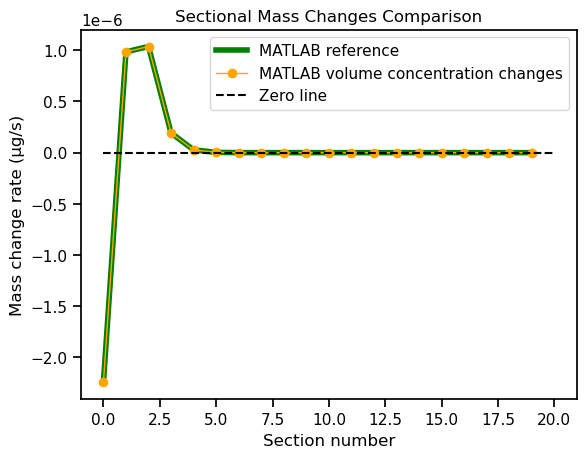

In [12]:
fig, ax = plt.subplots()
# ax.plot(sectional_mass_changes.data, label='Native volume concentration changes')
ax.plot(dvdt, label='MATLAB reference', linewidth=4, color='green')
ax.plot(sectional_volume_concentration_changes_matlab.data, label='MATLAB volume concentration changes', color='orange', linewidth=1, marker='o')
ax.hlines(0, 0, 20, linestyles='dashed', colors='k', label='Zero line')

ax.set_xlabel('Section number')
ax.set_ylabel('Mass change rate (μg/s)')
ax.set_title('Sectional Mass Changes Comparison')
ax.legend()
plt.show()

Negative values at for the first class represent a decrease in volume concentration in this class while all larger classes increase.

### Time evolution

Once all the components are constructed (e.g. coagulation kernel, sectional coagulation kernels) then the actual time evolution is performed from within the particle size distribution class.
The results of the integration are stored in particle_size_distribution.data (and .time)

In [13]:
particle_size_distribution.perform_time_evolution(
    sectional_volume_concentration_changes_matlab,
    t_max=timedelta(seconds=1).total_seconds(), 
    dt=timedelta(seconds=0.01).total_seconds(), 
    integration_method='LSODA')
# LSODA is a "stiff sovler" that is more robust to solving the ODEs because the particle size distribution is only defined for positive values.

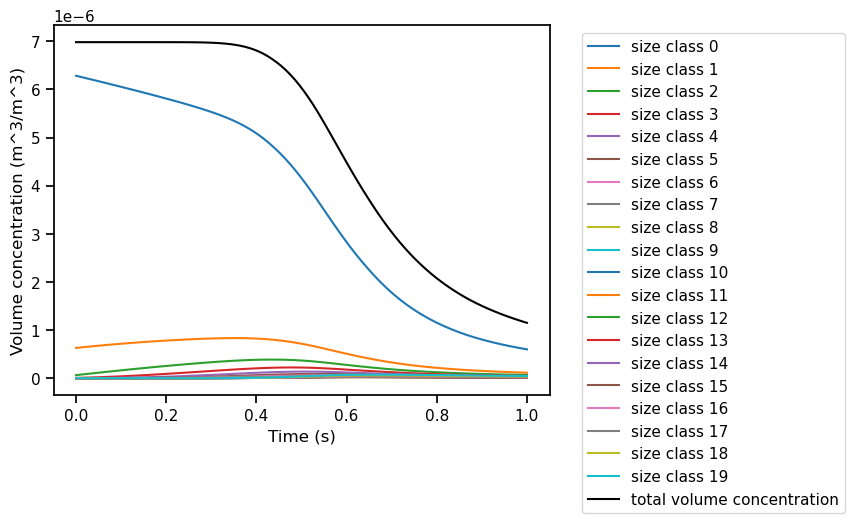

In [14]:
for ii in range(particle_size_distribution.number_size_classes):
    plt.plot(particle_size_distribution.time,particle_size_distribution.data[:,ii], label=f'size class {ii}')

# Plot sum of all size classes
plt.plot(particle_size_distribution.time,np.sum(particle_size_distribution.data,axis=1), color='k', label='total volume concentration')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# axis labels
plt.xlabel('Time (s)')
plt.ylabel('Volume concentration (m^3/m^3)')
plt.show()